In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from model_builder import ModelBuilder

In [4]:
import json

In [5]:
from var_table import VarTable

In [6]:
var_table = VarTable()

In [7]:
group_names = ['G0', 'G1', 'G2', 'G3', 'G4', 'G5']

In [8]:
experiment_number = 1

In [9]:
M = 10 ** 10
k = 3

In [10]:
config = {
    'k': k
}

In [11]:
solvers = ['glpk', 'cbc', 'mpec_minlp', 'ilogcp', 'random']

In [12]:
fitnesses_dataset = {}
durations_dataset = {}

In [13]:
# fitness
for solver in solvers:
    fitnesses_dataset[solver] = []

In [14]:
# duration
for solver in solvers[:-1]:
    durations_dataset[solver] = []

In [15]:
fitnesses_dataset['variables'] = []
fitnesses_dataset['constraints'] = []

In [16]:
def find_data_by_name(dataset, name):
    for data in dataset:
        data_name = data['name']
        if data_name == name:
            return data

In [17]:
def find_solution_by_config(solutions, config):
    for solution in solutions:
        solution_config = solution['config']
        if solution_config == config:
            return solution

In [18]:
def draw_durations_polt(df):
    plt.title('durations')
    plt.xlabel('G')
    plt.ylabel('duration, sec')
    sns.lineplot(data=df)

In [19]:
def read_matrixes(group_name, experiment_number):
        nested_directory = var_table.get_nested_directory(group_name, experiment_number)
        T_file_path = '{}/T.csv'.format(nested_directory)
        D_file_path = '{}/D.csv'.format(nested_directory)
        sum_D_file_path = '{}/sum_D.csv'.format(nested_directory)
        C_file_path = '{}/C.csv'.format(nested_directory)
        E_file_path = '{}/E.csv'.format(nested_directory)
        T_df = pd.read_csv(T_file_path, index_col=False, header=None)
        D_df = pd.read_csv(D_file_path, index_col=False, header=None)
        sum_D_df = pd.read_csv(sum_D_file_path, index_col=False, header=None)
        C_df = pd.read_csv(C_file_path, index_col=False, header=None)
        E_df = pd.read_csv(E_file_path, index_col=False, header=None)
        T = T_df.to_numpy()
        D = D_df.to_numpy()
        sum_D = sum_D_df.to_numpy()
        C = C_df.to_numpy()
        E = E_df.to_numpy()
        return T, sum_D, C, E

In [20]:
# fitness
for group_name in group_names:
    nested_directory = var_table.get_nested_directory(group_name, experiment_number)
    file_path = '{}/solutions.json'.format(nested_directory)
    file = open(file_path, 'r')
    content = file.read()
    dataset = json.loads(content)
    file.close()
    for solver in solvers:
        data = find_data_by_name(dataset, solver)
        solutions = data['solutions']
        solution = find_solution_by_config(solutions, config)
        result = solution['result']
        fitness = result['fitness']
        fitnesses_dataset[solver].append(fitness)

In [21]:
# duration
for group_name in group_names:
    nested_directory = var_table.get_nested_directory(group_name, experiment_number)
    file_path = '{}/solutions.json'.format(nested_directory)
    file = open(file_path, 'r')
    content = file.read()
    dataset = json.loads(content)
    file.close()
    for solver in solvers[:-1]:
        data = find_data_by_name(dataset, solver)
        solutions = data['solutions']
        solution = find_solution_by_config(solutions, config)
        result = solution['result']
        duration = result['duration']
        durations_dataset[solver].append(duration)

In [22]:
for group_name in group_names:
    T, sum_D, C, E = read_matrixes(group_name, experiment_number)
    model_builder = ModelBuilder(M, k, T, sum_D, C, E)
    model = model_builder.build()
    A_count = len(model.A)
    f_count = len(model.f)
    variables_count = A_count + f_count
    constraints_count = len(model.constraints)
    fitnesses_dataset['variables'].append(variables_count)
    fitnesses_dataset['constraints'].append(constraints_count)

In [23]:
fitnesses_df = pd.DataFrame(fitnesses_dataset)
fitnesses_df

,glpk,cbc,mpec_minlp,ilogcp,random,variables,constraints
0,-19.0,-19.0,-19.0,-19.0,-19.0,69,126
1,-167.0,-185.0,-167.0,-310.0,-310.0,335,733
2,-466.0,-251.0,-466.0,-466.0,-466.0,1413,3015
3,-1956.0,-1613.0,-1956.0,-2068.0,-2068.0,5173,12763
4,-4501.0,-2674.0,-4501.0,-4878.0,-4878.0,6501,13831
5,-23179.0,-19554.0,-23179.0,-23395.0,-23395.0,15825,40380


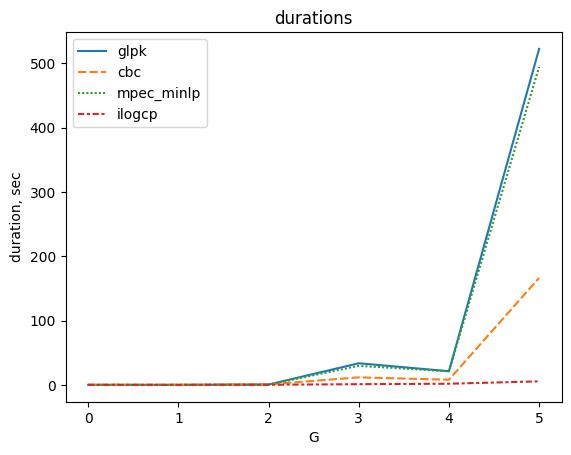

In [24]:
durations_df = pd.DataFrame(durations_dataset)
draw_durations_polt(durations_df)

### Выводы:
1. ilogcp находит решение неотличающееся от рандомного
2. cbc (COIN-OR Branch-and-Cut solver) фаворит: лучшее решение за меньшее время